This file will be used to train the policies and use them to generate the trajectories. 

Let's start by creating the environment we will be using: Cartpool

In [10]:
%load_ext autoreload
%autoreload 2
%aimport -numpy
%aimport -torch
%aimport -gym

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
torch.manual_seed(0)

# for saving/loading
import os

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
env = gym.make('CartPole-v0')
env.seed(0)

C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[0]

For the definition of classes and functions for training the policies, refer to train_policy_func.py file 

In [13]:
# to test

from Train_policy_func import Policy, device
from Generate_traj_func import generate_trajectory

policy = Policy(state_size=4, action_size=2).to(device)
# optionally: policy.load_state_dict(torch.load("best_policy.pth"))

# Generate one trajectory: 
traj = generate_trajectory(policy, env)
print(f"Episode length: {len(traj)}, Total reward: {sum(s['reward'] for s in traj)}")



Episode length: 17, Total reward: 17.0


In [14]:
# Training loop for PPO

from PPO import ppo_update, RolloutBuffer

# "In practice you’ll often tune these three carefully":
# clip_eps in [0.1, 0.3]
# lam in [0.90, 0.98]
# lr in [1e-5, 1e-3]"

# Hyperparameters
env_name     = "CartPole-v0"
total_steps  = 1000     # per update
updates      = 2000        # how many times to run rollout+update
clip_eps     = 0.2      # PPO clipping parameter
gamma, lam   = 0.99, 0.95 # GAE parameters
lr           = 0.001
batch_size   = 64
epochs       = 4

# Instantiate
env       = gym.make(env_name)
policy    = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=lr)
buffer    = RolloutBuffer()
avg_returns = []

for update in range(updates):
    state = env.reset()
    steps = 0

    # for tracking episode returns within this batch
    episode_rewards     = []
    current_ep_reward   = 0.0

    # 1) Roll out until we have total_steps
    while steps < total_steps:
        action, logp, value = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        buffer.store(state, action, logp, reward, value, done)
        state = next_state
        steps += 1

        # accumulate for this episode
        current_ep_reward += reward

        if done:
            episode_rewards.append(current_ep_reward)
            current_ep_reward = 0.0
            state = env.reset()

    # in case the last episode didn’t terminate exactly on total_steps
    if current_ep_reward > 0.0:
        episode_rewards.append(current_ep_reward)

    # compute average return for this batch
    avg_ret = np.mean(episode_rewards)
    avg_returns.append(avg_ret)

    # 2) Compute last value (for GAE)
    _, last_value = policy(torch.from_numpy(state).float().unsqueeze(0).to(device))

    # 3) PPO update
    ppo_update(policy, optimizer, buffer, clip_eps, epochs, batch_size)

    # 4) Saving checkpoint of the policy to get pi2
    if (update ) % 200 == 0 and update < 300:
        print(f"Update {update}/{updates} completed.")
        torch.save(policy.state_dict(), f"pi2_checkpoint_{update}.pth")

# 5) at the end, save pi1
torch.save(policy.state_dict(), "pi1_final.pth")
print("Saved final policy as pi1_final.pth")



c:\Users\turin\OneDrive\EPFL\Master\MA2\RL\RLHF\Git RLHF\RL-RLHF\PPO.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v  = torch.tensor(v).float().to(device)


Update 0/2000 completed.
Update 200/2000 completed.
Saved final policy as pi1_final.pth


In [15]:
## Generate preference pairs

# Load π₂ (weak) and π₁ (strong)
from pairs_generator import sample_preference_pairs

pi2 = Policy().to(device)
pi2.load_state_dict(torch.load("pi2_checkpoint_200.pth"))
pi2.eval()

pi1 = Policy().to(device)
pi1.load_state_dict(torch.load("pi1_final.pth"))
pi1.eval()

# Generate one trajectory each to inspect
traj1 = generate_trajectory(pi1, env, max_steps=1000)
traj2 = generate_trajectory(pi2, env, max_steps=1000)

print(f"π₂ → length {len(traj2)}, total reward {sum(s['reward'] for s in traj2):.1f}")
print(f"π₁ → length {len(traj1)}, total reward {sum(s['reward'] for s in traj1):.1f}")

prefs = sample_preference_pairs(pi1, pi2, env, K=200) # Need to define K elsewhere as hyperparameter
print(f"Collected {len(prefs)} preference pairs.")


C:\Users\turin\AppData\Local\Temp\ipykernel_66704\2183349200.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi2.load_state_dict(torch.load("pi2_checkpoint_200.pth"))
C:

π₂ → length 19, total reward 19.0
π₁ → length 46, total reward 46.0
Collected 200 preference pairs.


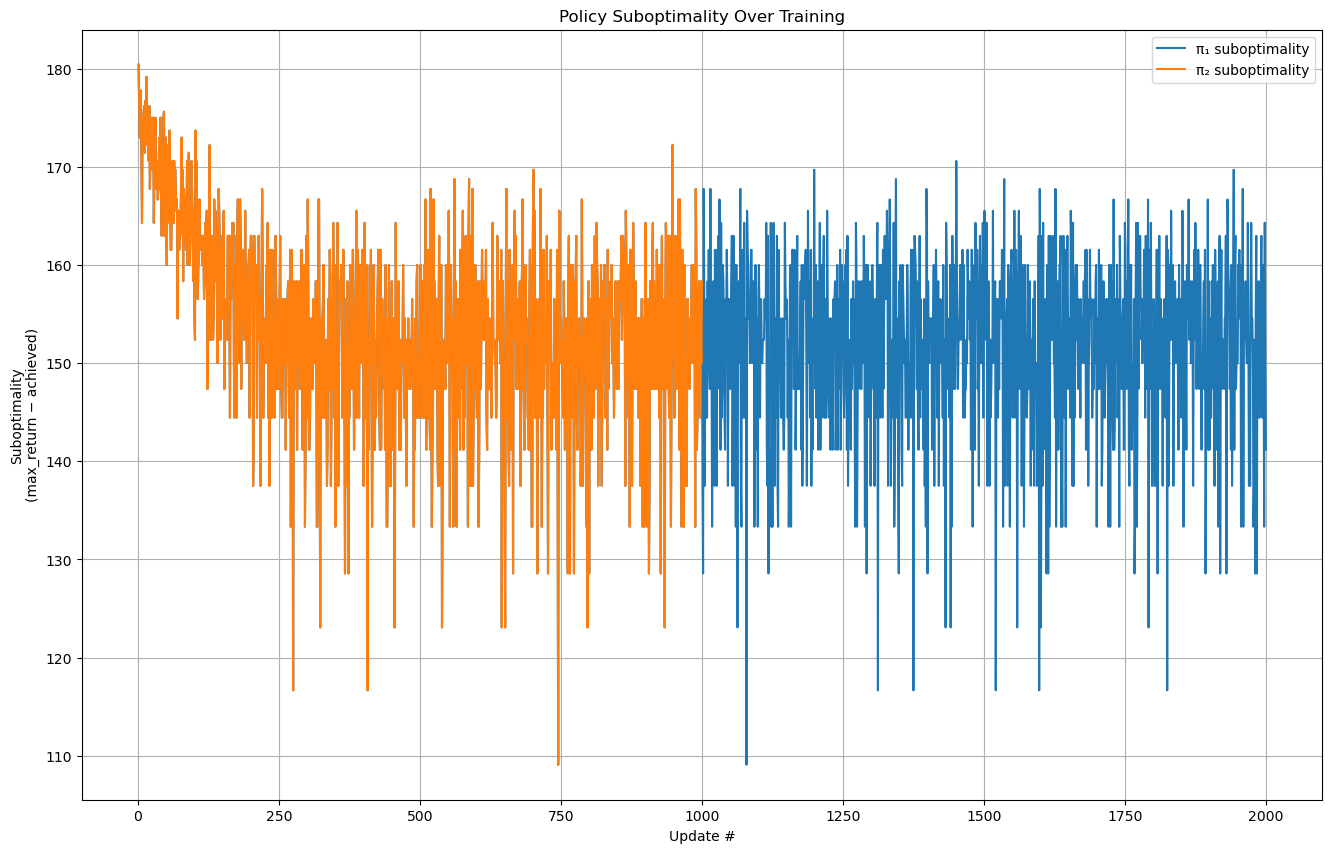

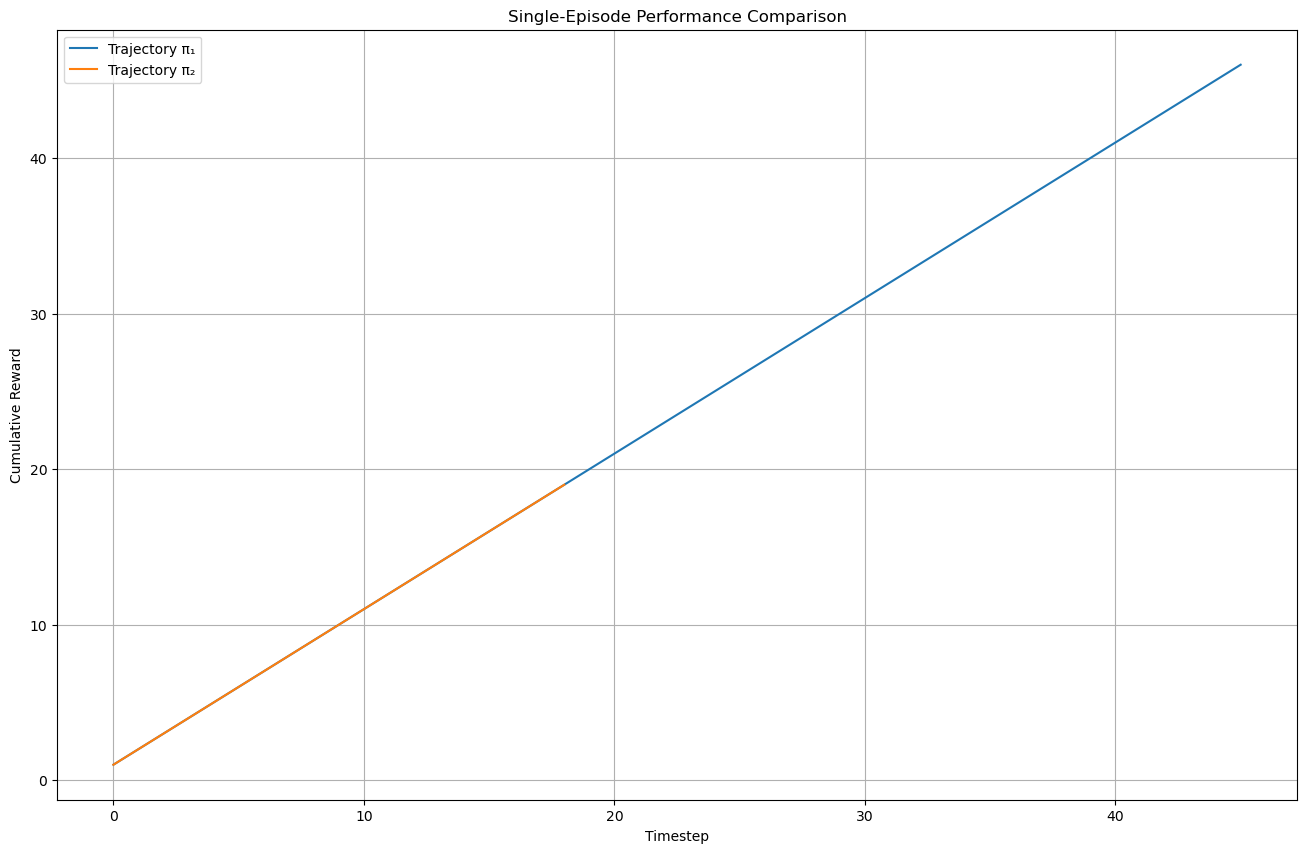

 size traj1: 46, size traj2: 19


In [16]:
## Visulization of the policies and trajectories
# %autoreload 2
from Generate_traj_func import plot_suboptimality, plot_trajectory_performance


plot_suboptimality(avg_returns, avg_returns[0:int(len(avg_returns)/2)],200) #in cartpole, 200 is the maximum reward
plot_trajectory_performance(traj1, traj2) 
print(f" size traj1: {len(traj1)}, size traj2: {len(traj2)}")

Episode 100	Average Score: 25.64
Episode 200	Average Score: 27.30
Episode 300	Average Score: 40.37
Episode 400	Average Score: 86.54
Episode 500	Average Score: 155.89
Episode 600	Average Score: 184.38
Episode 700	Average Score: 181.01
Episode 800	Average Score: 189.76
Episode 900	Average Score: 196.95
Episode 1000	Average Score: 194.94
Episode 1100	Average Score: 195.90
Episode 1200	Average Score: 193.56
Episode 1300	Average Score: 193.44
Episode 1400	Average Score: 198.47
Episode 1500	Average Score: 195.84
Episode 1600	Average Score: 198.58
Episode 1700	Average Score: 198.93
Episode 1800	Average Score: 198.51
Episode 1900	Average Score: 198.25
Episode 2000	Average Score: 199.11


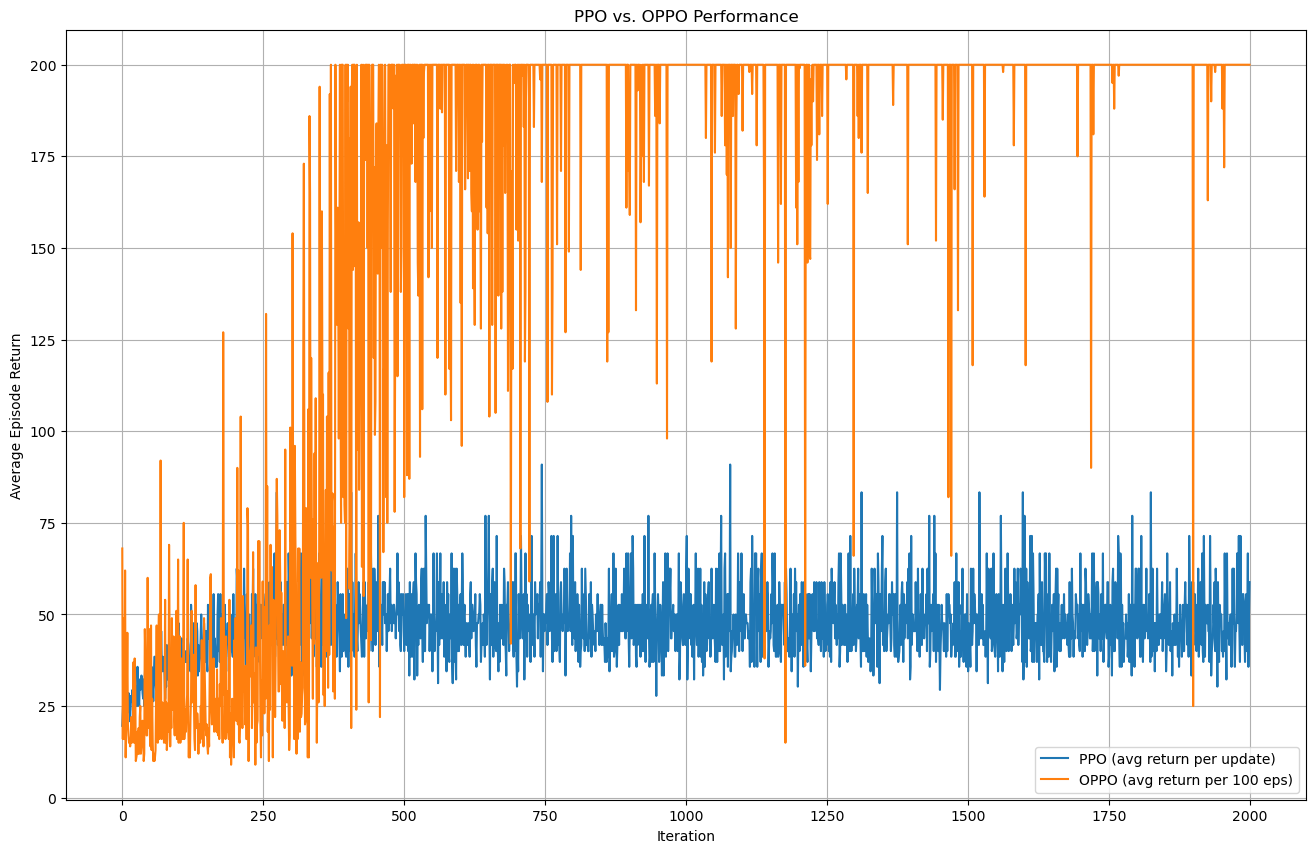

In [ ]:
# Training loop for OPPO
from OPPO import baseline_1, OPPO_update
from Train_policy_func import Policy, device


# ── Re-instantiate a fresh policy & optimizer for OPPO ──
env_oppo   = gym.make(env_name)
policy_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
opt_oppo    = torch.optim.Adam(policy_oppo.parameters(), lr=lr)

# ── Hyperparams for OPPO ──
n_episodes = updates      # keep same “number of iterations” for fair comparison
max_t      = total_steps  # cap on steps per episode
print_every=100

# ── Run the OPPO training ──
scores_oppo = OPPO_update(
    policy       = policy_oppo,
    optimizer    = opt_oppo,
    env          = env_oppo,
    baseline     = baseline_1,
    n_episodes   = n_episodes,
    max_t        = max_t,
    gamma        = gamma,      # you can reuse your PPO γ
    print_every  = print_every,
    early_stop   = False
)

# ── Post-processing: smooth or average returns per “block” if you like
avg_scores_oppo = [
    np.mean(scores_oppo[i : i + print_every])
    for i in range(0, len(scores_oppo), print_every)
]



import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    np.arange(len(avg_returns)), avg_returns,
    label="PPO (avg return per update)"
)
plt.plot(
    np.arange(len(avg_scores_oppo)), avg_scores_oppo,
    label=f"OPPO (avg return per {print_every} eps)"
)
plt.plot(
    np.arange(len(scores_oppo)), scores_oppo,
    label=f"OPPO (avg return per {print_every} eps)"
)
plt.xlabel("Iteration")
plt.ylabel("Average Episode Return")
plt.legend()
plt.grid(True)
plt.title("PPO vs. OPPO Performance")
plt.show()

